Work in progress!

# The Acrobot

*We recommend you look at the [Introduction to Crocoddyl](introduction_to_crocoddyl.ipynb) example before this one.*

In the example, we model the acrobot control problem using Crocoddyl. An acrobot is a two joint planar robot with only one actuator. It is a canonnical example of an underactuated system and so presents an interesting control problem.

We demonstrate how to:

1. Load a model from an urdf.
1. Define an actuation mapping for the system.
1. Construct and solve the control problem.

## Loading the model
A standalone double pendulum robot urdf is provided in the [example-robot-data](https://github.com/Gepetto/example-robot-data) repository, this comes bundled with Crocoddyl. Let's load the model and inspect its properties.

In [ ]:
import os
import pathlib

import numpy as np
import pinocchio

# Get the path to the urdf
from example_robot_data.path import EXAMPLE_ROBOT_DATA_MODEL_DIR
import example_robot_data

import crocoddyl


# Now load the model (using pinocchio)
robot = example_robot_data.load("double_pendulum_simple")
#robot = pinocchio.robot_wrapper.RobotWrapper.BuildFromURDF(str(urdf_model_path))

# The model loaded from urdf (via pinicchio)
print(robot.model)

# Create a multibody state from the pinocchio model.
state = crocoddyl.StateMultibody(robot.model)

Nb joints = 3 (nq=2,nv=2)
  Joint 0 universe: parent=0
  Joint 1 joint1: parent=0
  Joint 2 joint2: parent=1



`pinocchio` comes with some handy wrappers that load a robot along with vizual and collision models. These are all defined via that urdf. `robot.model` is the model is a model of the DAEs (Differential Algebraic Equations).

You will notice that the there are two joint configurations `nq` and velocities `nv`.

## Actuation Mapping
In order to create an underactuated double pendulum, the acrobot, we will create mapping between control inputs and joint torques. This is done by inheriting from `ActuationModelAbstract`. See also `ActuationModelFloatingBase` and `ActuationModelFull` for other options.

In [17]:
# Define the control signal to actuated joint mapping
class AcrobotActuationModel(crocoddyl.ActuationModelAbstract):
    def __init__(self, state):
        nu = 1  # Control dimension
        crocoddyl.ActuationModelAbstract.__init__(self, state, nu=nu)

    def calc(self, data, x, u):
        assert len(data.tau) == 2
        # Map the control dimensions to the joint torque
        data.tau[0] = 0
        data.tau[1] = u

    def calcDiff(self, data, x, u):
        # Specify the actuation jacobian
        data.dtau_du[0] = 0
        data.dtau_du[1] = 1


# Also see ActuationModelFloatingBase and ActuationModelFull
actuationModel = AcrobotActuationModel(state)
# actuationModel = crocoddyl.ActuationModelFloatingBase(state)

## Constructing the Problem

Before we solve the control problem, we need to construct the cost models and action models.

In [3]:
dt = 1e-3  # Time step
T = 1000  # Number of knots

# Cost models
runningCostModel = crocoddyl.CostModelSum(state, nu=actuationModel.nu)
terminalCostModel = crocoddyl.CostModelSum(state, nu=actuationModel.nu)

# Add a cost for the configuration positions and velocities
xref = np.array([0, 0, 0, 0])  # Desired state
stateResidual = crocoddyl.ResidualModelState(state, xref=xref, nu=actuationModel.nu)
stateCostModel = crocoddyl.CostModelResidual(state, stateResidual)
runningCostModel.addCost("state_cost", cost=stateCostModel, weight=1e-5 / dt)
terminalCostModel.addCost("state_cost", cost=stateCostModel, weight=1000)

# Add a cost on control
controlResidual = crocoddyl.ResidualModelControl(state, nu=actuationModel.nu)
bounds = crocoddyl.ActivationBounds(np.array([-1.0]), np.array([1.0]))
activation = crocoddyl.ActivationModelQuadraticBarrier(bounds)
controlCost = crocoddyl.CostModelResidual(
    state, activation=activation, residual=controlResidual
)
runningCostModel.addCost("control_cost", cost=controlCost, weight=1e-1 / dt)

# Create the action models for the state
runningModel = crocoddyl.IntegratedActionModelEuler(
    crocoddyl.DifferentialActionModelFreeFwdDynamics(
        state, actuationModel, runningCostModel
    ),
    dt,
)
terminalModel = crocoddyl.IntegratedActionModelEuler(
    crocoddyl.DifferentialActionModelFreeFwdDynamics(
        state, actuationModel, terminalCostModel
    ),
    0.0,
)

Now we define the control problem.

In [ ]:
# Define a shooting problem
q0 = np.zeros((state.nq,))      # Inital joint configurations
q0[0] = np.pi / 2               # Down
v0 = np.zeros((state.nv,))      # Initial joint velocities
x0 = np.concatenate((q0, v0))   # Inital robot state
problem = crocoddyl.ShootingProblem(x0, [runningModel] * T, terminalModel)

Let's test the system with a rollout.

/tmp/ipykernel_17167/1529456559.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data.tau[1] = u


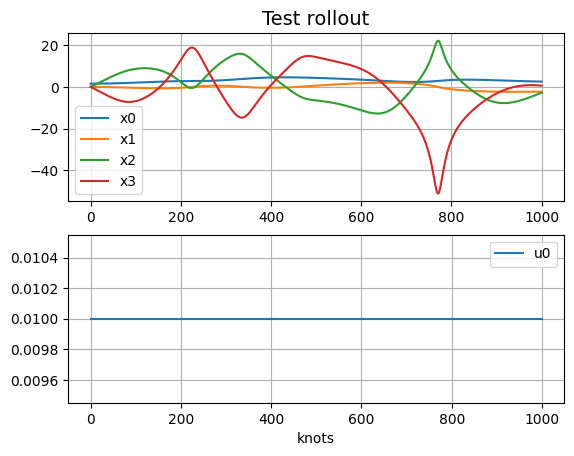

In [5]:
# Test the problem with a rollout
us = [0.01 * np.ones((1,))] * T
xs = problem.rollout(us)

# Handy to blat up the state and control trajectories
crocoddyl.plotOCSolution(xs, us, show=False, figIndex=99, figTitle="Test rollout")

# Put a grid on the plots
import matplotlib.pyplot as plt

fig = plt.gcf()
axs = fig.axes
for ax in axs:
    ax.grid()

Now we can solve the optimal control problem.

In [6]:
# Now stabilize the acrobot using FDDP
solver = crocoddyl.SolverFDDP(problem)

# Solve
callbacks = []
callbacks.append(crocoddyl.CallbackLogger())
callbacks.append(crocoddyl.CallbackVerbose())
solver.setCallbacks(callbacks)
solver.solve([], [], 300, False, 1e-5)

/tmp/ipykernel_17167/1529456559.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data.tau[1] = u


iter    cost       merit      stop      |grad|      preg       dreg      step   ||ffeas||  ||gfeas||  ||hfeas||   dV-exp       dV      dPhi-exp     dPhi
   0  1.459e+01  0.000e+00  1.039e+02  2.078e+02  1.000e-05  1.000e-05  0.1250  1.571e+00  0.000e+00  0.000e+00 -2.151e+01 -1.459e+01  0.000e+00  0.000e+00
   1  1.470e+01  0.000e+00  4.389e+00  5.061e+00  1.000e-05  1.000e-05  0.0156  1.374e+00  0.000e+00  0.000e+00 -7.185e-02 -1.099e-01  0.000e+00  0.000e+00
   2  1.466e+01  0.000e+00  3.875e-01  2.681e+00  1.000e-05  1.000e-05  0.0156  1.353e+00  0.000e+00  0.000e+00  4.643e-02  3.729e-02  0.000e+00  0.000e+00
   3  1.454e+01  0.000e+00  2.938e+00  8.929e+00  1.000e-05  1.000e-05  0.0156  1.332e+00  0.000e+00  0.000e+00  1.419e-01  1.243e-01  0.000e+00  0.000e+00
   4  1.430e+01  0.000e+00  5.209e+00  1.315e+01  1.000e-05  1.000e-05  0.0156  1.311e+00  0.000e+00  0.000e+00  2.064e-01  2.392e-01  0.000e+00  0.000e+00
   5  1.403e+01  0.000e+00  6.940e+00  1.624e+01  1.000e-05  1.000e

True

  91  1.508e+00  0.000e+00  5.612e-10  1.122e-09  1.000e-09  1.000e-09  1.0000  0.000e+00  0.000e+00  0.000e+00  5.612e-10  7.958e-10  0.000e+00  0.000e+00


We can visualize the trajectory with `meshcat` or using `gepetto-gui` (you will need to install [gepetto-viewer]() and [gepetto-viewer-corba]() and start the process in a separate terminal.)

In [7]:
# Display using meshcat
robot_display = crocoddyl.MeshcatDisplay(robot, -1, 1, False)
display(robot_display.robot.viewer.jupyter_cell())
robot_display.displayFromSolver(solver)

# Display using gepetto-gui
if False:
    robot_display = crocoddyl.GepettoDisplay(robot, floor=False)
    robot_display.displayFromSolver(solver)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


Opening in existing browser session.


We can plot the trajectory and the solver's convergence properties.

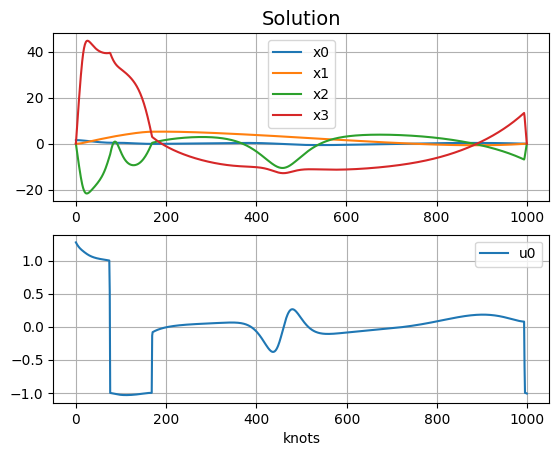

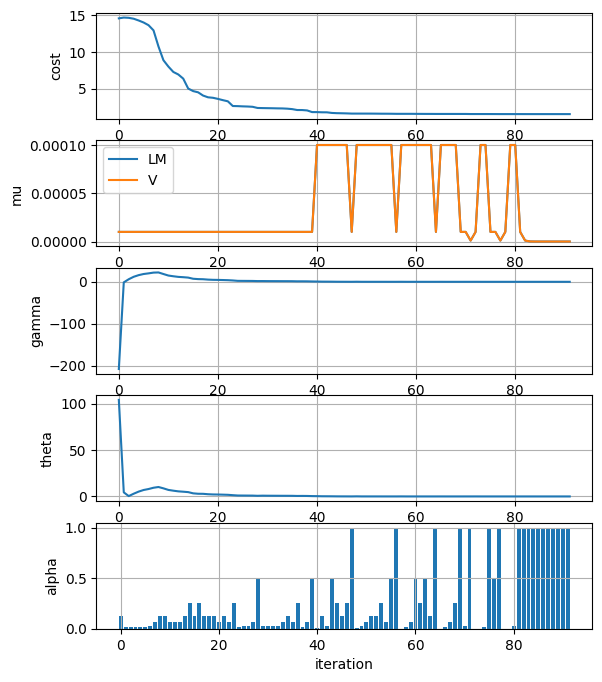

In [8]:
# Plotting the solution and the DDP convergence
log = solver.getCallbacks()[0]

import matplotlib.pyplot as plt

crocoddyl.plotOCSolution(
    xs=log.xs, us=log.us, show=False, figIndex=1, figTitle="Solution"
)
fig = plt.gcf()
axs = fig.axes
for ax in axs:
    ax.grid(True)

crocoddyl.plotConvergence(
    log.costs,
    log.pregs,
    log.dregs,
    log.grads,
    log.stops,
    log.steps,
    show=False,
    figIndex=2,
)
fig = plt.gcf()
axs = fig.axes
for ax in axs:
    ax.grid(True)

plt.show()